# MATH50003 (2023–24)
# Revision Lab

In [1]:
using LinearAlgebra, SetRounding, Test

**Problem 1(a)** Simpson's rule on a single panel is given by
$$
∫_a^b f(x) {\rm d}x ≈ {b-a \over 6} \left[f(a) + 4 f\!\left({a+b \over 2}\right) + f(b) \right].
$$
Complete the implementation of `simpsonsrule` by dividing $[0,1]$ into grid points $x_0, x_1, …, x_{2n}$ with $x_k = k/(2n)$
and applying Simpson's rule on the intervals $[x_{2k-2},x_{2k}]$ for $k = 1,…,n$.

In [2]:
function simpsonsrule(f, n)
    sum = 0
    for k in 1:n
        xk = (k - 1) / n
        xk1 = k / n

        sum += (f(xk) + 4*f((xk + xk1)/2) + f(xk1)) / (6 * n)
    end

    sum
end

@test simpsonsrule(exp, 1000) ≈ exp(1)-1

Test Passed
  Expression: simpsonsrule(exp, 1000) ≈ exp(1) - 1
   Evaluated: 1.7182818284590444 ≈ 1.718281828459045

**Problem 1(b)** By computing with various values of $n$, conjecture what the convergence rate is as $n → ∞$. Is it faster than Trapezium rules $O(n^{-2})$?

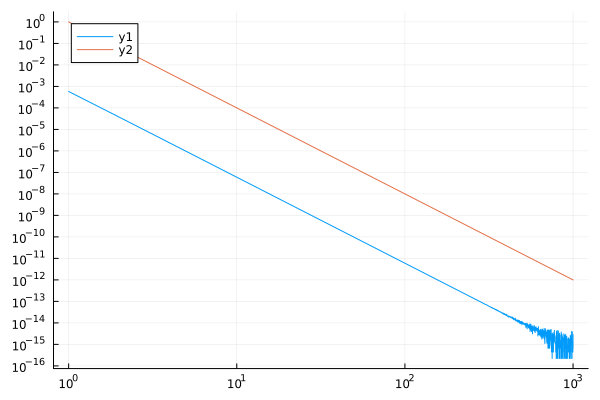

In [3]:
using Plots
nanabs = x -> iszero(x) ? NaN : abs(x)
errs = [nanabs((simpsonsrule(exp, n) - (exp(1)-1))) for n = 1:1000]

plot(1:1000, errs; yscale=:log10, xscale=:log10, xticks=10 .^ (0:3), yticks=10.0 .^ (-(0:16)))
plot!(1:1000, (1:1000) .^ (-4))


**Problem 2** Consider a 3-term divided-difference approximation
$$
f'(x) ≈ {5f(x+2h) - 3f(x) - 2f(x-h) \over 12h}
$$
Implement this in the following function.

In [4]:
function threeterm_divideddifference(f, x, h)
    (5f(x + 2h) - 3f(x) - 2f(x-h)) / (12h)

end
@test threeterm_divideddifference(exp, 0, 0.0000001) ≈ 1 atol=1E-5

Test Passed
  Expression: ≈(threeterm_divideddifference(exp, 0, 1.0e-7), 1, atol = 1.0e-5)
   Evaluated: ≈(1.0000000753388842, 1; atol = 1.0e-5)

**Problem 3** Using the following simplified `Dual` implementation, consider a double-dual number
like `Dual(Dual(a,b), Dual(c,d))`. By choosing `a`, `b`, `c` and `d`, construct the function `secondderivative(f, x)`
that computes the second derivative of a function. Hint: it might help to think of a double-dual number as
$(a + b*ε) + δ*(c + d*ε)$ where $ε^2 = δ^2 = 0$.

In [5]:
struct Dual
    a
    b
end

import Base: +, *, exp
function +(x::Dual, y::Dual)
    a,b = x.a, x.b # x == a+bϵ. This gets out a and b
    c,d = y.a, y.b # y == c+dϵ. This gets out c and d
    Dual(a+c, b+d)
end
function *(x::Dual, y::Dual)
    a,b = x.a, x.b # x == a+bϵ. This gets out a and b
    c,d = y.a, y.b # y == c+dϵ. This gets out c and d
    Dual(a*c, b*c + a*d)
end
exp(x::Dual) = Dual(exp(x.a), exp(x.a) * x.b)


function secondderivative(f, x)
    f(Dual(Dual(x, 1), Dual(1, 0))).b.b
end

f = x -> exp(x*exp(x))
@test secondderivative(f, 0) ≈ 3

Test Passed
  Expression: secondderivative(f, 0) ≈ 3
   Evaluated: 3.0 ≈ 3

**Problem 4** Implement the following function
`primedigits` that constructs a positive `Float64` of the form $2^q * (1.b_1…b_S)$
where the exponent is specified by `q` and has significand
bits
$$
b_k = \begin{cases}
    1 & k\hbox{ is prime} \\
    0 & \hbox{otherwise}
    \end{cases}
$$
Hint: use the `gcd` function to determine if a number is prime.

In [6]:

function primedigits(q)
    function isprime(k)
        if k ≤ 1
            return false
        end
        for j=1:k-1
            if gcd(k, j) ≠ 1
                return false
            end
        end
        return true
    end

    ret = "1"

    for k = 1:52
        if isprime(k)
            ret *= "1"
        else
            ret *= "0"
        end
    end

    2.0^(q - 52) * parse(Int, ret; base=2)
end

@test primedigits(3) == 11.317460078808892

Test Passed
  Expression: primedigits(3) == 11.317460078808892
   Evaluated: 11.317460078808892 == 11.317460078808892

**Problem 5** Implement the `sqrt` function with correctly rounded interval arithmetic.

In [7]:
struct Interval # represents the set [a,b]
    a # left endpoint
    b # right endpoint
end

Interval(x) = Interval(x,x) # Support Interval(1) to represent [1,1]

import Base: sqrt, in
in(x, X::Interval) = X.a ≤ x ≤ X.b

function sqrt(X::Interval)
    a,b = promote(X.a, X.b) # make sure all are the same type
    T = typeof(a)
    if (a < 0) || (b < 0)
        error("Cannot take square root of negative interval")
    end

    sqrtA = setrounding(T, RoundDown) do
        sqrt(a)
    end
    sqrtB = setrounding(T, RoundUp) do
        sqrt(b)
    end

    Interval(sqrtA, sqrtB)
end

@test sqrt(big(2.0)) in sqrt(Interval(2.0))

Test Passed
  Expression: sqrt(big(2.0)) in sqrt(Interval(2.0))
   Evaluated: 1.414213562373095048801688724209698078569671875376948073176679737990732478462102 in Interval(1.414213562373095, 1.4142135623730951)

**Problem 6(a)**  Consider the Schrödinger equation with quadratic oscillator:
$$
u(-L) = u(L) = 0, -u'' + x^2 u = f(x)
$$
Use row-eliminations to recast the tridiagonal finite-difference discretisation as a symmetric tridiagonal
system, solved via the `SymTridiagonal` type,.

In [9]:
function schrodingersolve(n, L, f)
    x = range(-L,L;length=n+1) # discretisation grid
    #Implement finite differences using a SymTridiagonal matrix, by using the knowledge of the solution at ±L.
    h = step(x)
    A = SymTridiagonal(2/h^2 .+  x[2:end-1].^2, fill(-1/h^2, n-2))
    [0; A \ f.(x[2:end-1]); 0]
end

f = x-> 2exp(-x^2) - 3exp(-x^2)*x^2
n,L = 10000,10
x = range(-L,L;length=n+1)
@test schrodingersolve(n, L, f) ≈ exp.(-x.^2) atol=1E-4

Test Passed
  Expression: ≈(schrodingersolve(n, L, f), exp.(-(x .^ 2)), atol = 0.0001)
   Evaluated: ≈([0.0, 3.866768738215705e-30, 7.735083565305567e-30, 1.1606489951089856e-29, 1.5482533363410738e-29, 1.9364759884219164e-29, 2.3254716824919275e-29, 2.715395334121592e-29, 3.1064021047710017e-29, 3.4986474632485816e-29  …  3.498647740790194e-29, 3.1064023511964726e-29, 2.7153955495291774e-29, 2.3254718669675484e-29, 1.9364761420391868e-29, 1.5482534591613173e-29, 1.1606490871812512e-29, 7.735084178916289e-30, 3.866769044959743e-30, 0.0], [3.720075976020836e-44, 3.871879669107162e-44, 4.0298457175443513e-44, 4.1942229558553083e-44, 4.365270212541999e-44, 4.543256709289263e-44, 4.728462476023973e-44, 4.921178782459839e-44, 5.121708586776794e-44, 5.330367002110765e-44  …  5.330367002110765e-44, 5.121708586776794e-44, 4.921178782459839e-44, 4.728462476023973e-44, 4.543256709289263e-44, 4.365270212541999e-44, 4.1942229558553083e-44, 4.0298457175443513e-44, 3.871879669107162e-44, 3.720075976

**Problem 6(b)** The `eigvals` function computes eigenvalues of a matrix. Use this alongside the
symmetric diagonal discretisation to approximate $λ$ such that
$$
u(-L) = u(L) = 0, -u'' + x^2 u = λ u
$$
has a non-zero solution (i.e., an eigenvalue of the differential equation).
Can you conjecture their exact value if $L → ∞$?

In [10]:
function shrodingereigvals(n, L)
    x = range(-L,L;length=n+1) # discretisation grid
    # Use eigvals with a SymTridiagonal discretisation to approximate the eigenvalues of a Schrödinger operator
    h = step(x)
    eigvals(SymTridiagonal(2/h^2 .+  x[2:end].^2, fill(-1/h^2, n-1)))
end

shrodingereigvals (generic function with 1 method)

**Problem 7** Implement `reversecholesky(A)` that returns an upper-triangular matrix `U` such that `U*U' ≈ A`.
You may assume the input is symmetric positive definite and has `Float64` values. You must not use the inbuilt `cholesky`
function or in any other way reduce the problem to a standard Cholesky factorisation.

In [15]:
function reversecholesky(A)
    n,m = size(A)
    if n ≠ m
        error("Matrix must be square")
    end
    if A ≠ A'
        error("Matrix must be symmetric")
    end
    U = UpperTriangular(zeros(n,n))
    Aⱼ = copy(A)
    for j = n:-1:1
        α,𝐯 = Aⱼ[j,j],Aⱼ[1:j-1,j]
        U[j,j] = sqrt(α)
        U[1:j-1,j] = 𝐯/sqrt(α)
        Aⱼ = Aⱼ[1:j-1,1:j-1] - 𝐯*𝐯'/α
    end

    U
end

A = [2 1 0; 1 2 1; 0 1 2]
U = reversecholesky(A)
@test U*U' ≈ A

Test Passed
  Expression: U * U' ≈ A
   Evaluated: [2.0000000000000004 1.0 0.0; 1.0 1.9999999999999998 1.0; 0.0 1.0 2.0000000000000004] ≈ [2 1 0; 1 2 1; 0 1 2]

**Problem 8** Complete the function `lagrangebasis(g, k, x)` where `g` is a vector of grid
points, that computes the Lagrange basis function at the point `x`. You may assume all numbers
are `Float64`.

In [16]:
function lagrangebasis(g::AbstractVector, k, x)
    n = length(g) # number of points
    ## TODO: compute ℓ_k(x) corresponding to the grid g
    ℓ_k = 1
    for i = 1:n
        if i ≠ k
            ℓ_k *= (x - g[i]) / (g[k] - g[i])
        end
    end
    ℓ_k
end

g = 1:5
@test lagrangebasis(g, 2, 2) == 1
@test lagrangebasis(g, 2, 3) == lagrangebasis(g, 2, 4) ==  0
@test lagrangebasis(g, 3, 0.1) ≈ 8.169525

Test Passed
  Expression: lagrangebasis(g, 3, 0.1) ≈ 8.169525
   Evaluated: 8.169525 ≈ 8.169525

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*